# Produce a XR-clean kDST

<i>
This notebook takes a kDST and filters the data to produce
a XR-clean kDST in order to facilitate the Kr analysis.
</i>

<i>
In presence of external gamma sources, the XR production
is very significative and constitutes a source of
background for Kr data. This NB filters the data to
produce a rather pure dataset on which to perform
the regular analysis.
</i>

### Notebook configuration

In [1]:
run_number          = 5858
input_dst_filename  = f"$IC_DATA/RunIV/kdst_{run_number}.h5"
correction_filename =  "$IC_DATA/XYmaps/run4628_corrections.h5"
output_dst_filename = input_dst_filename.replace(".h5", "_filtered.h5")

n_sigma = 3
Zrange  = 100,  550
Zfit    = 200,  500
Erange  = 2e3, 20e3
Znbins  =  50
Enbins  = 100

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15
with_titles  = True

### Imports

In [2]:
import os
import time

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers

from icaro.core.fit_functions import fit_slices_1d_gauss
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)

%matplotlib inline

### Initialization

In [3]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Fri Jun 15 22:51:17 2018


In [4]:
input_dst_filename  = os.path.expandvars( input_dst_filename)
correction_filename = os.path.expandvars(correction_filename)
output_dst_filename = os.path.expandvars(output_dst_filename)

Zbins = np.linspace(*Zrange, Znbins + 1)
Ebins = np.linspace(*Erange, Enbins + 1)

Zcenters = shift_to_bin_centers(Zbins)
Zerror   = np.diff(Zbins) * 0.5

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Read data

In [5]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
dst           = dst[dst.nS1 == 1]
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 322664 
Total number of events: 315298


In [6]:
if "index" in dst: del dst["index"]

In [7]:
XYcorrection = dstf.load_xy_corrections(correction_filename,
                                        norm_strategy =  "index",
                                        norm_opts     = {"index": (25, 25)})

In [8]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
T = dst.time.values - dst.time.values.min()
E = dst.S2e.values * XYcorrection(X, Y).value

### Data filtering

In [9]:
sel_e = in_range(E, *Erange)
mean, sigma, chi2, ok = fit_slices_1d_gauss(Z[sel_e], E[sel_e], Zbins, Ebins, min_entries=5e2)
ok = ok & in_range(Zcenters, *Zfit)

In [10]:
x         = Zcenters[ok]
y         = mean.value[ok] - n_sigma * sigma.value[ok]
yu        = mean.uncertainty[ok]
seed      = expo_seed(x, y)
lowE_fit  = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
assert np.all(lowE_fit.values != seed)

x         = Zcenters[ok]
y         = mean.value[ok] + n_sigma * sigma.value[ok]
yu        = mean.uncertainty[ok]
seed      = expo_seed(x, y)
highE_fit = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
assert np.all(highE_fit.values != seed)

lowE_cut  =  lowE_fit.fn
highE_cut = highE_fit.fn

[ 11963.54053634  -1537.42025729]


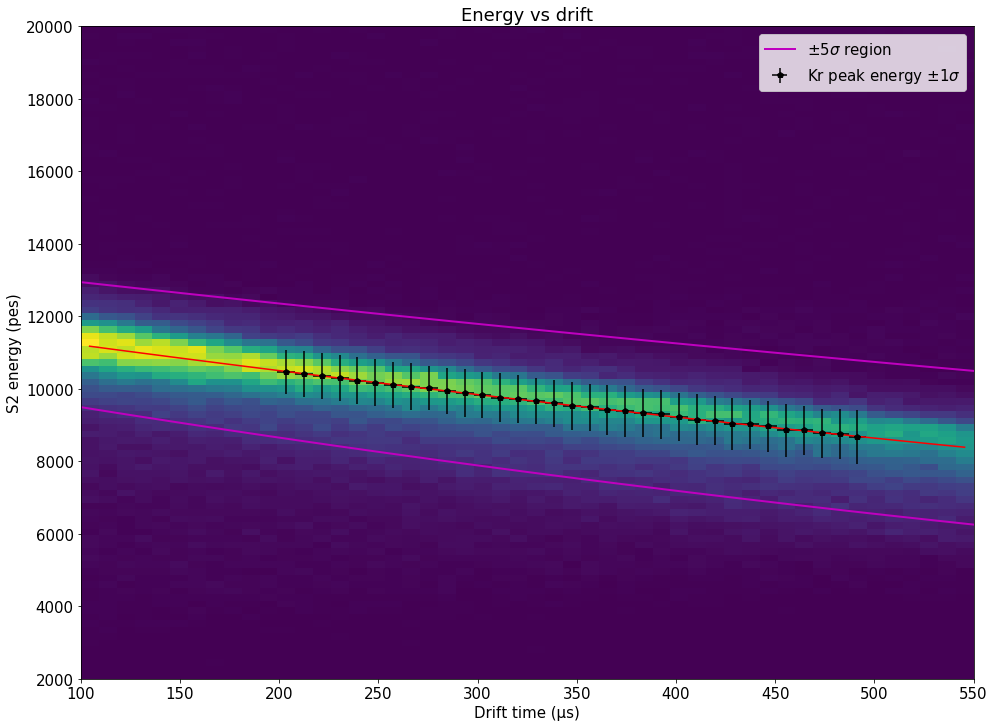

In [11]:
plt.hist2d  (Z, E, (Zbins, Ebins), cmap=default_cmap)
plt.errorbar(   Zcenters[ok], mean.value[ok],
             sigma.value[ok],     Zerror[ok],
             "kp", label="Kr peak energy $\pm 1 \sigma$")
f = fitf.fit(fitf.expo, Zcenters[ok], mean.value[ok], (1e4, -1e3))
plt.plot(Zcenters, f.fn(Zcenters), "r-")
print(f.values)
plt.plot    (Zbins,  lowE_cut(Zbins),  "m", lw=2, label="$\pm 5 \sigma$ region")
plt.plot    (Zbins, highE_cut(Zbins),  "m", lw=2)
plt.legend()
labels("Drift time (µs)", "S2 energy (pes)", "Energy vs drift")

### Produce filtered kDST

In [12]:
subdst = dst[in_range(E, lowE_cut(Z), highE_cut(Z))]
unique_events = ~subdst.event.duplicated()

number_of_S2s_filtered  = np.size         (unique_events)
number_of_evts_filtered = np.count_nonzero(unique_events)

number_of_S2s_ratio  = number_of_S2s_filtered  / number_of_S2s_full  * 100
number_of_evts_ratio = number_of_evts_filtered / number_of_evts_full * 100

print(f"Total number of S2s   : {number_of_S2s_filtered} ({number_of_S2s_ratio:.1f} %)" )
print(f"Total number of events: {number_of_evts_filtered} ({number_of_evts_ratio:.1f} %)")

Total number of S2s   : 274256 (85.0 %)
Total number of events: 273676 (86.8 %)


In [13]:
# Unfortunately, this method can't set a specific name to the table or its title.
# It also includes an extra column ("index") which I can't manage to remove.
subdst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)

# Workaround to re-establish the name of the table and its title
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

### Comparison between original and filtered data

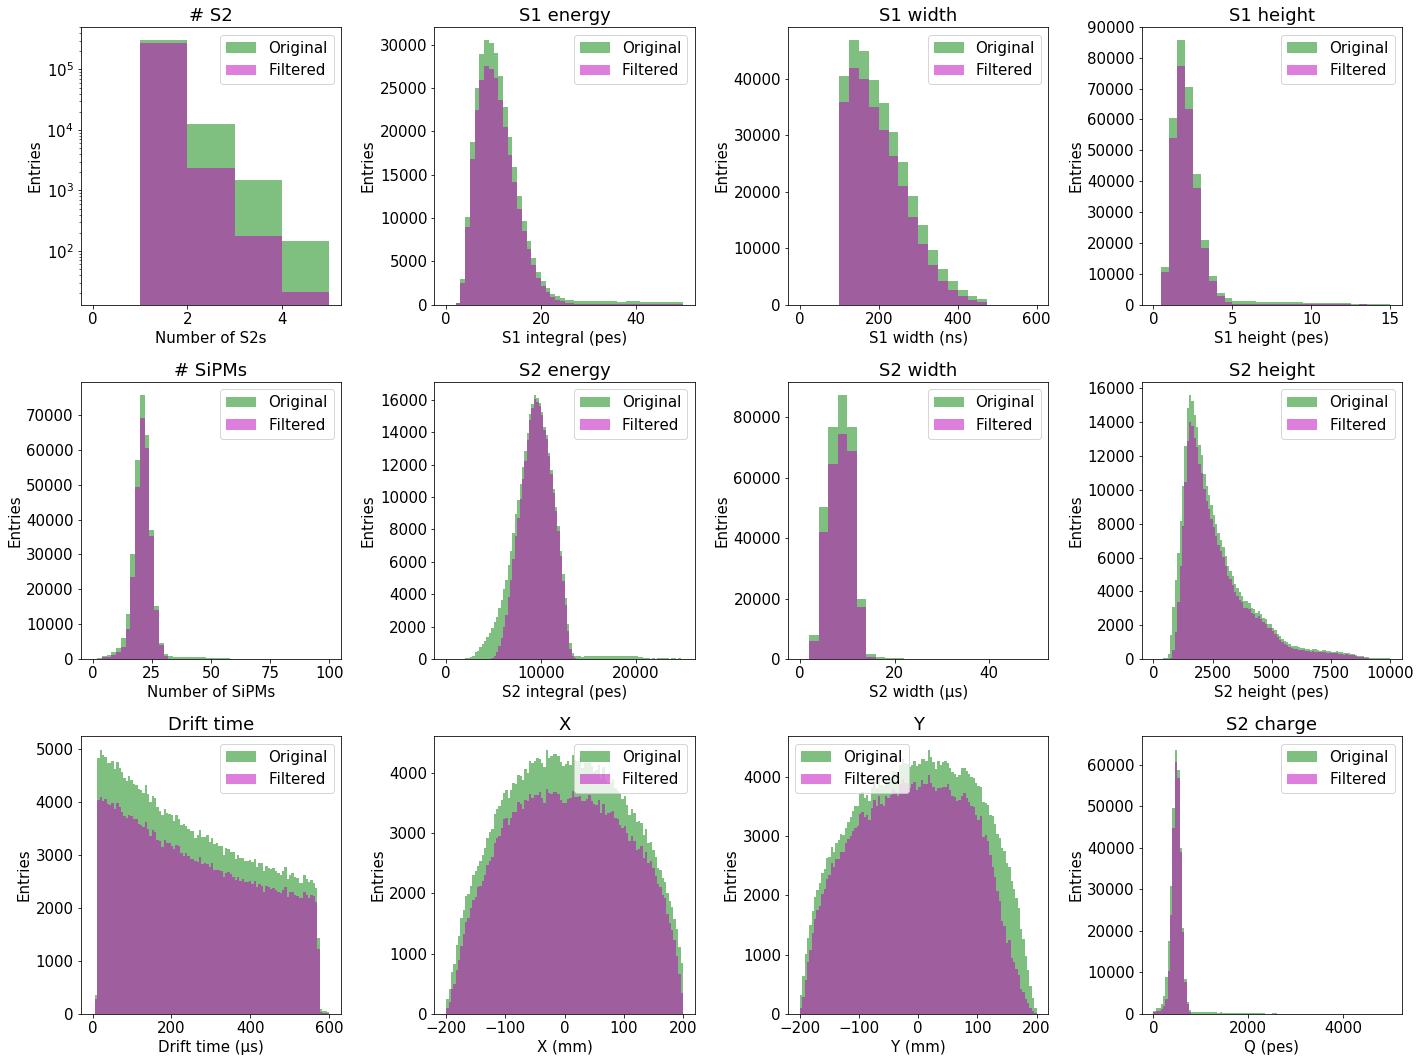

In [14]:
def double_hist(h1, h2, binning, label0="Original", label1="Filtered", **kwargs):
    plt.hist(h1, binning, label=label0, alpha=0.5, color="g", **kwargs)
    plt.hist(h2, binning, label=label1, alpha=0.5, color="m", **kwargs)
    plt.legend()

plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
double_hist(dst.nS2, subdst.nS2, np.linspace(0, 5, 6))
plt.yscale("log")
labels("Number of S2s", "Entries", "# S2")

plt.subplot(3, 4, 2)
double_hist(dst.S1e, subdst.S1e, np.linspace(0, 50, 51))
labels("S1 integral (pes)", "Entries", "S1 energy")

plt.subplot(3, 4, 3)
double_hist(dst.S1w, subdst.S1w, np.linspace(0, 600, 25))
labels("S1 width (ns)", "Entries", "S1 width")

plt.subplot(3, 4, 4)
double_hist(dst.S1h, subdst.S1h, np.linspace(0, 15, 31))
labels("S1 height (pes)", "Entries", "S1 height")

plt.subplot(3, 4, 5)
double_hist(dst.Nsipm, subdst.Nsipm, np.linspace(0, 100, 51))
labels("Number of SiPMs", "Entries", "# SiPMs")

plt.subplot(3, 4, 6)
double_hist(dst.S2e, subdst.S2e, np.linspace(0, 25e3, 101))
labels("S2 integral (pes)", "Entries", "S2 energy")

plt.subplot(3, 4, 7)
double_hist(dst.S2w, subdst.S2w, np.linspace(0, 50, 26))
labels("S2 width (µs)", "Entries", "S2 width")

plt.subplot(3, 4, 8)
double_hist(dst.S2h, subdst.S2h, np.linspace(0, 1e4, 101))
labels("S2 height (pes)", "Entries", "S2 height")

plt.subplot(3, 4, 9)
double_hist(dst.Z, subdst.Z, np.linspace(0, 600, 101))
labels("Drift time (µs)", "Entries", "Drift time")

plt.subplot(3, 4, 10)
double_hist(dst.X, subdst.X, np.linspace(-200, 200, 101))
labels("X (mm)", "Entries", "X")

plt.subplot(3, 4, 11)
double_hist(dst.Y, subdst.Y, np.linspace(-200, 200, 101))
labels("Y (mm)", "Entries", "Y")

plt.subplot(3, 4, 12)
double_hist(dst.S2q, subdst.S2q, np.linspace(0, 5e3, 101))
labels("Q (pes)", "Entries", "S2 charge")

plt.tight_layout()